# Sun Access Notebook

## 0. Initialization

### 0.1. Importing libraries

In [1]:
import EN_17037_Recipes as enr 
import os
import trimesh as tm 
import pyvista as pv
import ladybug as lb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import colors
from honeybee_plus.radiance.recipe.solaraccess.gridbased import SolarAccessGridBased
from honeybee_plus.radiance.analysisgrid import AnalysisGrid

Path to radiance is set to: /usr/local/radiance
Path to perl is set to: /usr/bin


### 0.2. Setting global variables

In [2]:
# directory variables
cwd = os.getcwd()
src = os.path.dirname(cwd)

# project name
project_name = 'EN_17037_sun_access_5min'

# create the material dictionary
material_dict = {
    "material_plastic": enr.material_plastic,
    "material_glass": enr.material_glass
}

# load the surface information table
surface_df = pd.read_csv("sa_file_table.csv")
surface_df

,surface_name,surface_type,file_path,material_name
0,wall,0,ref_room_walls.obj,material_plastic
1,window,5,ref_room_window.obj,material_glass
2,context_buildings,0,test_context_01_buildings.obj,material_plastic


### 0.3. Prepare Analysis Information

In [3]:
# prepare grid points
grid_path = os.path.join(src, "data", "point_grid_sunacc.csv")
grid_array = np.genfromtxt(grid_path, delimiter=",")
pnts = [tuple(pnt) for pnt in grid_array] if len(grid_array.shape) == 2 else [tuple(grid_array)]
up_vecs = [(0, 0, 1)] * len(pnts)

# initiate sunpath
sp = lb.sunpath.Sunpath(longitude=4.3571, latitude=52.0116)

# define sun hours : A list of hours of the year for each sun vector
# there are 8760 hours in a year, so the following integers refer to specific hours throughout the year
hoys = []
sun_vectors = []
tstep = 5 # in minutes, integer
nsteps = 60 / tstep
tstep_frac = tstep / 60
hoy_range = np.arange(0, 8760, tstep_frac)
for i in hoy_range:
    # compute the sun object
    sun = sp.calculate_sun_from_hoy(i, is_solar_time=True)
    # extract the sun vector
    sun_vector = sun.sun_vector.to_array()
    # apparently, if the Z component of sun vector is positive, it is under the horizon 
    if sun_vector[2] < 0.0:
        hoys.append(i.round(2))
        sun_vectors.append(sun_vector)

In [4]:
max_hoy = 9997
hoys_batches = []
sun_vectors_batches = []
for s_low in range(0, len(hoys),max_hoy):
    s_up = s_low + max_hoy if s_low + max_hoy < len(hoys) else len(hoys)
    hoys_batches.append(hoys[s_low:s_up])
    sun_vectors_batches.append(sun_vectors[s_low:s_up])

In [5]:
hoy_sum = 0
for h in hoys_batches:
    hoy_sum += len(h)
hoy_sum, len(hoys), len(sun_vectors)

(53502, 53502, 53502)

## 1. Simulation

### 1.1. Importing geometries and assigning materials

In [6]:
# loading all meshes and converting them into hb surfaces
hb_surfaces = []
for _, srf in surface_df.iterrows():
    filepath = os.path.join(src, "data", srf["file_path"])
    mesh = pv.read(filepath)
    hb_surf = enr.pv_mesh_to_hbsurface(mesh, srf["surface_type"], srf["surface_name"], material_dict[srf["material_name"]])
    hb_surfaces.extend(hb_surf)

### 1.2. Create Recipe

In [7]:
rp_batches = []
for h_batch, sv_batch in zip(hoys_batches, sun_vectors_batches):
    # create analysis grid
    analysis_grid = AnalysisGrid.from_points_and_vectors(pnts, up_vecs, 'test_grid')
    # put the recipe together
    rp = SolarAccessGridBased(sv_batch, h_batch, [analysis_grid], timestep=int(1/tstep_frac), hb_objects=hb_surfaces)
    rp_batches.append(rp)

Found 12169 opaque surfaces.
Found 1 fenestration surfaces.
Found 0 window-groups.
Found 12169 opaque surfaces.
Found 1 fenestration surfaces.
Found 0 window-groups.
Found 12169 opaque surfaces.
Found 1 fenestration surfaces.
Found 0 window-groups.
Found 12169 opaque surfaces.
Found 1 fenestration surfaces.
Found 0 window-groups.
Found 12169 opaque surfaces.
Found 1 fenestration surfaces.
Found 0 window-groups.
Found 12169 opaque surfaces.
Found 1 fenestration surfaces.
Found 0 window-groups.


### 1.3. Create Batch Files

In [8]:
bfiles_batches = []
for i, rp_batch in enumerate(rp_batches):
    # write simulation to folder
    batch_file = rp_batch.write(
        target_folder='.', project_name = project_name + '_b' + str(i))
    bfiles_batches.append(batch_file)

Writing recipe contents to: ./EN_17037_sun_access_5min_b0/solaraccess
Writing recipe contents to: ./EN_17037_sun_access_5min_b1/solaraccess
Writing recipe contents to: ./EN_17037_sun_access_5min_b2/solaraccess
Writing recipe contents to: ./EN_17037_sun_access_5min_b3/solaraccess
Writing recipe contents to: ./EN_17037_sun_access_5min_b4/solaraccess
Writing recipe contents to: ./EN_17037_sun_access_5min_b5/solaraccess


### 1.4. Run the simulation

In [9]:
# run the simulation
for rp_batch, bfile_batch in zip(rp_batches, bfiles_batches):
    rp_batch.run(bfile_batch, debug=False)

## 2. Results

### 2.1. Load and parse the results

In [10]:
def parse_results(rp, aggregate=False):

    df = pd.read_csv(rp._result_files, skiprows=13, sep='\t', header=None)

    if not aggregate:
        return df
    else:
        return df.sum(axis=1) / df.shape[0]

result_batches = []
for rp_batch in rp_batches:
    r = parse_results(rp_batch, aggregate=False)
    r = r.dropna(axis=1)
    result_batches.append(r)
result = pd.concat(result_batches, axis=1)
result

,0,1,2,3,4,5,6,7,8,9,...,3507,3508,3509,3510,3511,3512,3513,3514,3515,3516
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00106,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 2.2. Yearly Sun Access

<AxesSubplot:>

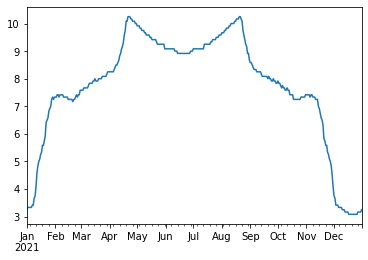

In [11]:
# reminder - the HOY indexes for the period 1st Feb and 21st March (included) are 258 and 774

point = 0
moy_range = np.round(np.array(hoy_range) * nsteps).astype(int) * tstep
moys = np.round(np.array(hoys) * nsteps).astype(int) * tstep
dates = pd.date_range(start='01-01-2021', end='31-12-2021 23:59:00', freq='%smin' % tstep)
result_timed = pd.DataFrame(index=list(moy_range), columns=['date','res','bin'], dtype='object')
result_timed['date'] = list(dates)
result_timed.loc[list(moys), 'res'] = result.iloc[point,:].values
result_timed['bin'] = 1
result_timed.index = dates
result_timed.loc[:,'bin'] = result_timed.loc[:,'bin'].where(result_timed['res']>0,other=0)

# count of hours with sunlight access in a day (01/02 - 21/03)
result_day = result_timed['bin'].resample('D').sum() / nsteps
result_day.plot()

### 2.3. Daily Sun Access

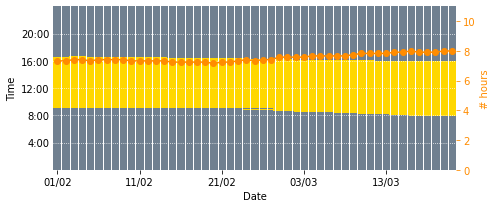

In [12]:
fig, ax1 = plt.subplots(figsize=(7,3))

ndays = 49 # days in the period 1st Feb and 21st March (included)

cmap = colors.ListedColormap(['slategrey', 'gold'])
bounds=[0,.5,1]
norm = colors.BoundaryNorm(bounds, cmap.N)

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.imshow(result_timed['2021-02-01':'2021-03-21']['bin'].values.reshape(ndays,-1).T, 
           aspect='auto', origin='lower', cmap=cmap, norm=norm)
ax1.set_ylabel('Time')
ax1.set_xlabel('Date')
ax1.set_yticks(range(0,int(24*nsteps),int(4*nsteps)))
ax1.set_yticklabels(['','4:00','8:00','12:00','16:00','20:00'])
ax1.tick_params(axis='y', length=0)
ax1.set_xticks(range(0,ndays,10))
ax1.set_xticklabels(['01/02','11/02','21/02','03/03','13/03'])
ax1.grid(axis='y', color='w', ls=':')
ax1.set_ylim(0,24*int(nsteps))

ax2 = ax1.twinx()

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
for i in range(ndays):
    ax2.axvline(i+0.5, color='w', lw=1)
ax2.plot(result_day['2021-02-01':'2021-03-21'].values, marker='o', color='darkorange')
ax2.set_ylabel('# hours', color='darkorange')
ax2.tick_params(axis='y', labelcolor='darkorange', color='darkorange')
ax2.set_ylim(0,11)


fig.tight_layout()
plot_path = os.path.join('plots', project_name + '_sunlight_hours_febmar.eps')
plt.savefig(plot_path, format='eps')
plt.show()

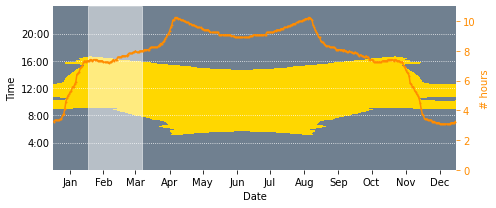

In [13]:
# Annual plot

fig, ax1 = plt.subplots(figsize=(7,3))

cmap = colors.ListedColormap(['slategrey', 'gold'])
bounds=[0,.5,1]
norm = colors.BoundaryNorm(bounds, cmap.N)

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)

ax1.imshow(result_timed['bin'].values.reshape(365,-1).T, 
           aspect='auto', origin='lower', cmap=cmap, norm=norm)
ax1.set_ylabel('Time')
ax1.set_xlabel('Date')
# I am sure there's a smarter way to do this, but for now it'll do:
ax1.set_xticks([15,45,74,105,135,166,196,227,258,288,319,350])
ax1.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
ax1.set_yticks(range(0,int(24*nsteps),int(4*nsteps)))
ax1.set_yticklabels(['','4:00','8:00','12:00','16:00','20:00'])
ax1.tick_params(axis='y', length=0)
ax1.grid(axis='y', color='w', ls=':')
ax1.set_ylim(0,24*int(nsteps))

ax2 = ax1.twinx()

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)

ax2.plot(result_day.values, marker='o', color='darkorange', ms=1, ls=None)
ax2.set_ylabel('# hours', color='darkorange')
ax2.tick_params(axis='y', labelcolor='darkorange', color='darkorange')
ax2.set_ylim(0,11)
ax2.axvspan(31, 80, alpha=0.5, color='white')

fig.tight_layout()
plot_path = os.path.join('plots', project_name + '_sunlight_hours_year.pdf')
plt.savefig(plot_path, format='pdf')
plt.show()